To perform predictive and inferential analysis without explicitly merging the datasets, we need to process and analyze them separately while ensuring that any analysis respects the original structure and relationships between the data. Here’s how you can proceed:

### Steps Without Merging:
1. Load and Optimize Data: Load each dataset separately and optimize the memory.
2. Correlation Analysis: Analyze correlations within each dataset without merging.
3. Feature Analysis: Focus on features within each dataset and apply analyses like regression or clustering without explicitly combining them.

### Breakdown of the Code:
#### Data Optimization:
The optimize_memory function ensures that the data types are appropriately adjusted to save memory, which is crucial when handling large datasets.

#### Correlation Analysis:
Correlation analysis is performed separately for geometries and simulations. This allows us to understand the relationships within each dataset without combining them. For instance, you can analyze how area_id in geometries might correlate with features like height or elevation.

#### Regression Analysis:
A linear regression is applied only to the simulations data. You can choose simulation features that are likely to correlate with area_id and use them as predictors to model and predict area_id.

#### Principal Component Analysis (PCA):
PCA is applied to reduce the dimensionality of simulations data, helping to identify the most important features that explain variability. This step can aid in visualizing the structure and relationships in the data.

#### Cluster Analysis:
K-means clustering is used to group similar simulation features without explicitly merging with geometries. The optimal number of clusters is determined using the silhouette score, and clusters are visualized to understand different patterns within the simulation features.

This approach maintains the integrity of each dataset and analyzes them independently while still leveraging relationships in the data.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
# Function to optimise memory usage
def optimise_memory(df):
    for col in df.select_dtypes(include=['float']):
        df[col] = pd.to_numeric(df[col], downcast='float', errors='coerce')
    for col in df.select_dtypes(include=['int']):
        df[col]=pd.to_numeric(df[col], downcast='integer', errors='coerce')
    return df

In [5]:
#Load geometries data
geometries = optimise_memory(pd.read_csv(r'E:\Data Analytics\Swiss Apartment Models\geometries.csv'))

In [7]:
# Load simulations data 
simulations = optimise_memory(pd.read_csv(r'E:\Data Analytics\Swiss Apartment Models\simulations.csv'))

In [9]:
# Correlation Analysis for Geometries
def correlation_analysis_geometries(geometries):
    correlations = geometries[['area_id', 'height']].corr()
    print('Correlation matrix for geometries:')
    print(correlations)

correlation_analysis_geometries(geometries)

Correlation matrix for geometries:
          area_id    height
area_id  1.000000  0.015571
height   0.015571  1.000000


In [11]:
# Correlation Analysis for Simulations
def correlation_analysis_simulations(simulations):
    correlations = simulations[['sun_201803210800_mean', 'view_ground_mean', 'connectivity_entrance_door_distance_mean']].corr()
    print('Correlation matrix for simulations:')
    print(correlations)

correlation_analysis_simulations(simulations)

Correlation matrix for simulations:
                                          sun_201803210800_mean  \
sun_201803210800_mean                                  1.000000   
view_ground_mean                                       0.684002   
connectivity_entrance_door_distance_mean               0.034194   

                                          view_ground_mean  \
sun_201803210800_mean                             0.684002   
view_ground_mean                                  1.000000   
connectivity_entrance_door_distance_mean         -0.001164   

                                          connectivity_entrance_door_distance_mean  
sun_201803210800_mean                                                     0.034194  
view_ground_mean                                                         -0.001164  
connectivity_entrance_door_distance_mean                                  1.000000  


In [15]:
def regression_analysis_simulations(simulations):
    # Select features correlated with area_id for regression analysis
    correlated_features = simulations[['sun_201803210800_mean', 'view_ground_mean', 'connectivity_entrance_door_distance_mean']]
    
    # Handle NaN values
    correlated_features = correlated_features.fillna(correlated_features.mean())  # Impute missing values with column means
    y = simulations['area_id'].fillna(simulations['area_id'].mean())  # Impute missing values for the target variable
    
    # Prepare the data
    X = correlated_features
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_scaled, y)
    
    # Predict and evaluate the model
    y_pred = model.predict(X_scaled)
    r_squared = model.score(X_scaled, y)
    
    print(f"Regression R-squared: {r_squared:.2f}")

regression_analysis_simulations(simulations)


Regression R-squared: 0.00


PCA Explained Variance Ratio: [0.5615993  0.33337206]


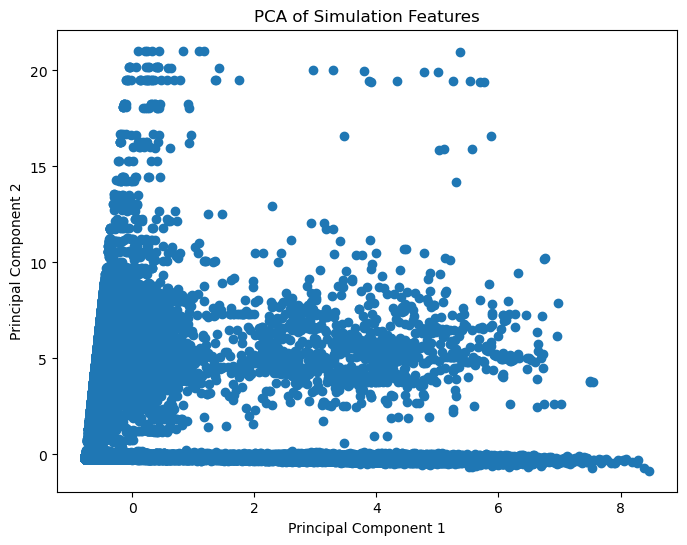

In [21]:
# Principal Component Analysis (PCA) for Simulations
def pca_analysis_simulations(simulations):
    pca_features = simulations[['sun_201803210800_mean', 'view_ground_mean', 'connectivity_entrance_door_distance_mean']]

    #Standardise the features
    scaler = StandardScaler()
    pca_features = pca_features.fillna(pca_features.mean())  # Impute missing values with column means
    pca_features_scaled = scaler.fit_transform(pca_features)

    # Apply PCA
    pca = PCA(n_components = 2)
    principal_components = pca.fit_transform(pca_features_scaled)

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"PCA Explained Variance Ratio: {explained_variance}")

    # Plot PCA components
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1])
    plt.title('PCA of Simulation Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

pca_analysis_simulations(simulations)

In [49]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def preprocess_simulations(simulations):
    """
    Preprocesses the simulations data by selecting numeric columns, 
    handling missing values, and scaling features.
    """
    numeric_simulations = simulations.select_dtypes(include=['number']).copy()
    numeric_simulations.fillna(numeric_simulations.mean(), inplace=True)
    scaler = StandardScaler()
    simulations_scaled = scaler.fit_transform(numeric_simulations)
    return numeric_simulations, simulations_scaled

In [51]:
def reduce_dimensions(simulations_scaled, n_components=2):
    """
    Reduces dimensions using PCA to speed up clustering.
    """
    pca = PCA(n_components=n_components, random_state=42)
    reduced_data = pca.fit_transform(simulations_scaled)
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return reduced_data

In [53]:
def sample_and_cluster(data, sample_size=10000, n_clusters=5):
    """
    Samples the data for clustering and assigns clusters to the full dataset.
    """
    # Sample the data
    sampled_indices = np.random.choice(data.shape[0], size=sample_size, replace=False)
    sampled_data = data[sampled_indices]
    
    # Perform clustering on sampled data
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=500, random_state=42)
    kmeans.fit(sampled_data)
    
    # Assign cluster labels to full dataset
    full_cluster_labels = kmeans.predict(data)
    return kmeans, full_cluster_labels, sampled_indices

In [55]:
def plot_clusters(reduced_data, cluster_labels, sampled_indices):
    """
    Plots clusters using reduced dimensions.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(
        reduced_data[sampled_indices, 0], 
        reduced_data[sampled_indices, 1], 
        c=cluster_labels[sampled_indices], cmap='viridis', marker='o'
    )
    plt.title('Clusters in Reduced Feature Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

Explained variance ratio: [0.36575092 0.05329148]


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


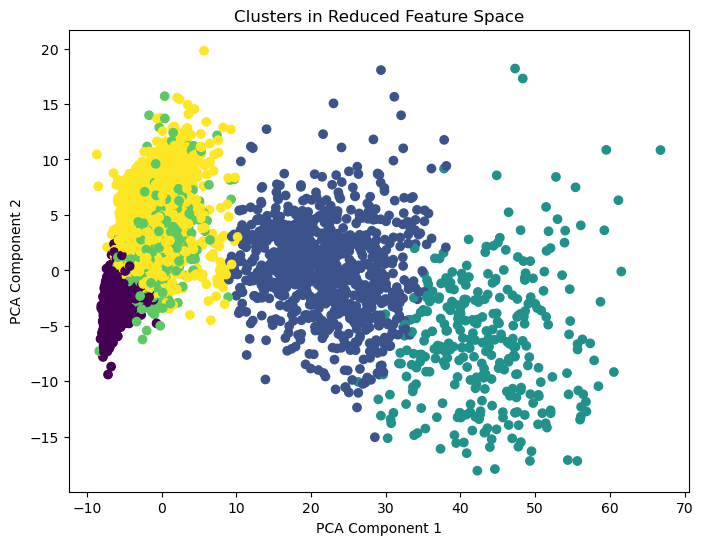

In [57]:
def cluster_analysis_simulations(simulations, sample_size=10000, n_clusters=5):
    """
    Executes the optimized clustering workflow.
    """
    # Preprocess the data
    numeric_simulations, simulations_scaled = preprocess_simulations(simulations)
    
    # Reduce dimensions for visualization
    reduced_data = reduce_dimensions(simulations_scaled, n_components=2)
    
    # Sample data and cluster
    kmeans, cluster_labels, sampled_indices = sample_and_cluster(simulations_scaled, sample_size, n_clusters)
    
    # Add cluster labels to the original DataFrame
    numeric_simulations['cluster'] = cluster_labels
    
    # Plot clusters in reduced dimensions (on sampled data)
    plot_clusters(reduced_data, cluster_labels, sampled_indices)
    
    return numeric_simulations, kmeans

# Example usage
# Load the simulations DataFrame
# simulations = pd.read_csv("simulations.csv")  # Uncomment and specify path to your data
clustered_data, kmeans_model = cluster_analysis_simulations(simulations, sample_size=10000, n_clusters=5)